В текущем мини-проекте проведем анализ данных компании (за два года: с 4 января 2015 по 3 января 2017.), которая занимается арендой велосипедов в Лондоне. Изучим динамику числа аренд, наличие связи с погодными условиями и выходными, а также объясним несколько аномалий на графике.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные, проверим число наблюдений и столбцов, наличие пропусков. Убедимся, что типы данных были прочитаны правильно. 

In [2]:
df = pd.read_csv(r"C:\Users\yarus\projects\data\london.csv", parse_dates=['timestamp'])

In [3]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Описание данных: \
timestamp – дата и время (точность до часа) \
cnt – количество аренд велосипедов за этот час \
t1 – температура, в С \
t2 – температура "ощущается как", в С \ 
hum – влажность (%) \
wind_speed – скорость ветра, км/ч \

weather_code – погодные условия: \
1 – ясно (SKC) \
2 – преимущественно ясно / встречаются отдельные облака (SCT) \
3 – облачно / значительные облака (BKN) \
4 – пасмурно (OVC) \
7 – небольшой дождь Rain/ light Rain shower/ Light rain  \
10 – дождь с грозой \
26 – снегопад \
94 – ледяной туман (да, такое бывает!) \

isholiday – является ли день праздником (1 – праздник, 0 – нет) \
isweekend –  является ли день выходным (1 – выходной, 0 – нет) \
season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [4]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

Посмотрим есть ли пропущенные значения.

In [5]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Для начала попробуем посмотреть на число поездок по датам и времени. Построим график, где: \
по оси x – дата (timestamp) \
по оси y – число поездок (cnt)

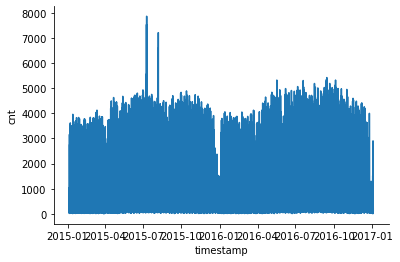

In [7]:
sns.lineplot(data=df, x=df.timestamp, y=df.cnt)
sns.despine()

Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды.

Преобразуем данные при помощи resample. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. 

In [8]:
df.sort_values(by='timestamp', inplace=True)

In [9]:
df.set_index('timestamp', drop=False, inplace=True)

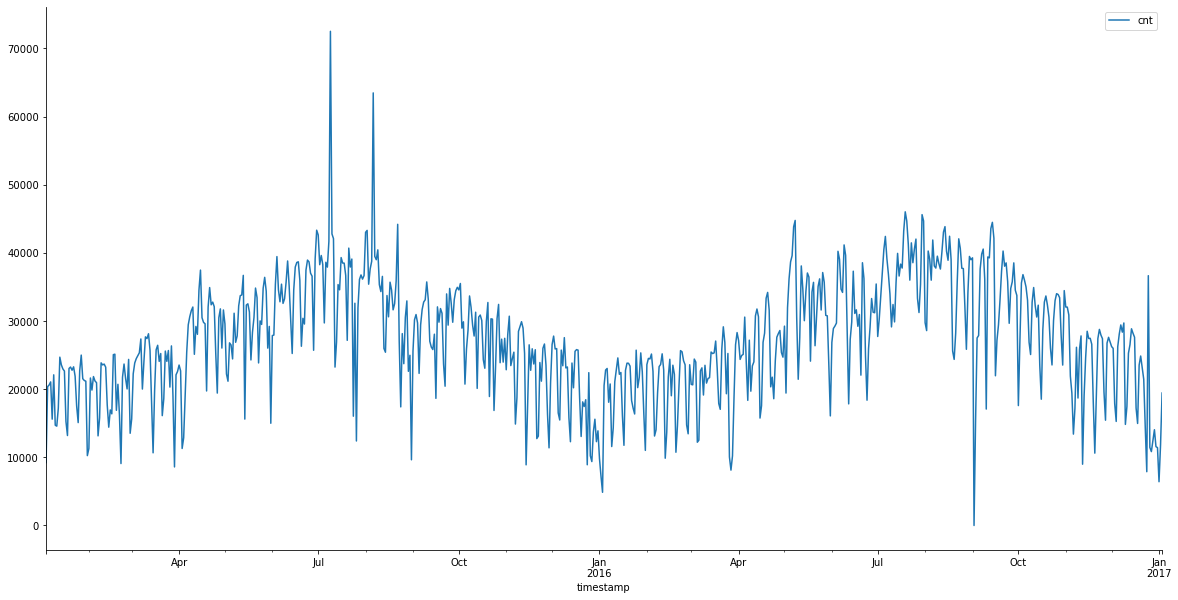

In [10]:
df.resample('D').agg({'cnt':'sum'}).plot(figsize=(20, 10))
sns.despine()

Зимой число аренд меньше, чем летом. \
Встречаются как очень резкие скачки числа аренд, так и падения. \
Максимальное число аренд за день составляет более 70 000.

Обнаружили на графике некоторые скачки, поэтому проверим, что же могло произойти в эти дни.

In [11]:
df_day = df.resample('D').cnt.sum().reset_index()

In [12]:
df_day.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


На данном шаге возьмем агрегированные данные по дням с предыдущего шага и посчитаем скользящее среднее с окном 3. 

In [13]:
df_day_rolling = df.resample('D').cnt.sum().rolling(window=3).mean().reset_index()

In [14]:
df_day_rolling.head()

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667


Теперь посчитаем разницу между наблюдаемыми и подсчитанными значениями. Далее – применим функцию для подсчета стандартного отклонения.

In [15]:
std = round(np.std(df_day['cnt'] - df_day_rolling['cnt']), 2)
std

4558.59

Теперь определим границы интервалов. Для этого возьмем данные, полученные при расчете скользящего среднего, и создадим следующие объекты: \
upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std \
lower_bound – нижняя граница; вычитаем 2.576∗std

Полученные значения запишем в новые столбцы датафрейма с агрегированными данными.

In [16]:
upper_bound = df_day_rolling.cnt + (2.576 * std)
lower_bound = df_day_rolling.cnt - (2.576 * std)

In [17]:
df_day['upper_bound'] = upper_bound
df_day['lower_bound'] = lower_bound

In [18]:
df_day.head()

,timestamp,cnt,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.594507,4996.738827
3,2015-01-07,21064,32425.927840,8940.072160
4,2015-01-08,15601,30835.594507,7349.738827


И наконец – изучим аномально высокие значения! Сначала выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

In [19]:
df_day.query('cnt > upper_bound')

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.927840,38962.072160
214,2015-08-06,63468,58370.261173,34884.405493
609,2016-09-04,27512,26001.927840,2516.072160
721,2016-12-25,36653,31393.594507,7907.738827


Наибольшая аномалия наблюдается 9 июля 2015 года. Поискав в открытых источниках, можно сделать вывод, что это связано с 
забастовкой в метро в Лондоне.

Проделаем аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. 

In [20]:
df_day.query('cnt < lower_bound')

,timestamp,cnt,upper_bound,lower_bound
130,2015-05-14,15609,40452.261173,16966.405493
189,2015-07-12,23240,47779.594507,24293.738827
201,2015-07-24,16034,42756.594507,19270.738827
232,2015-08-24,17400,41272.261173,17786.405493
314,2015-11-14,8898,32780.261173,9294.405493
607,2016-09-02,0,37829.261173,14343.405493
615,2016-09-10,17080,43004.927840,19519.072160
621,2016-09-16,21967,47936.261173,24450.405493
678,2016-11-12,8990,32620.927840,9135.072160


Сильная аномалия в значениях наблюдается 2 сентября 2016 года, что связано с ошибкой в сборе данных.